In [65]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
from os.path import join as pjoin

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as ut

### **1. Configuration**

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
DATA_DIR = '../data/CamVid'

In [10]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### **2. Data preparation**

In [43]:
class MyDataSet(BaseDataset):
    CLASSES = [
        'sky', 'building', 'pole', 'road', 'pavement', 
        'tree', 'signsymbol', 'fence', 'car', 
        'pedestrian', 'bicyclist', 'unlabelled'
    ]
    def __init__(self, image_dir, mask_dir, classes=None, augmentation=None, preprocessing=None,):
        self.classes = classes
        self.image_names = os.listdir(image_dir)
        self.image_fps = [pjoin(image_dir, image_name) for image_name in self.image_names]
        self.masks_fps = [pjoin(mask_dir, mask_name) for mask_name in self.image_names]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in self.classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.length = len(self.image_names)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        # read data
        image = cv2.imread(self.image_fps[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[index], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentation
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
        
        return image, mask

In [44]:
x_train_dir = os.path.join(DATA_DIR, 'train', 'images')
y_train_dir = os.path.join(DATA_DIR, 'train', 'masks')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'images')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'masks')

x_test_dir = os.path.join(DATA_DIR, 'test', 'images')
y_test_dir = os.path.join(DATA_DIR, 'test', 'masks')

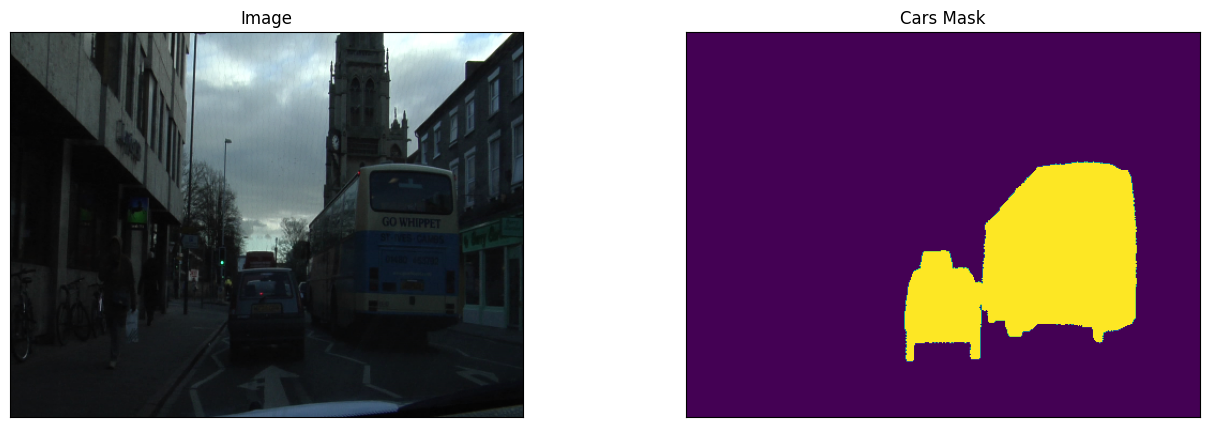

In [45]:
train_ds = MyDataSet(x_train_dir, y_train_dir, classes=['car'])

image, mask = train_ds[4] 
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [46]:
len(train_ds)

367

In [47]:
# Data augmentation
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    # Add paddings to make image shape divisible by 32 
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

'''
Construct preprocessing transform
Args:
    preprocessing_fn (callbale): data normalization function 
        (can be specific for each pretrained neural network)
Return:
    transform: albumentations.Compose
'''

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

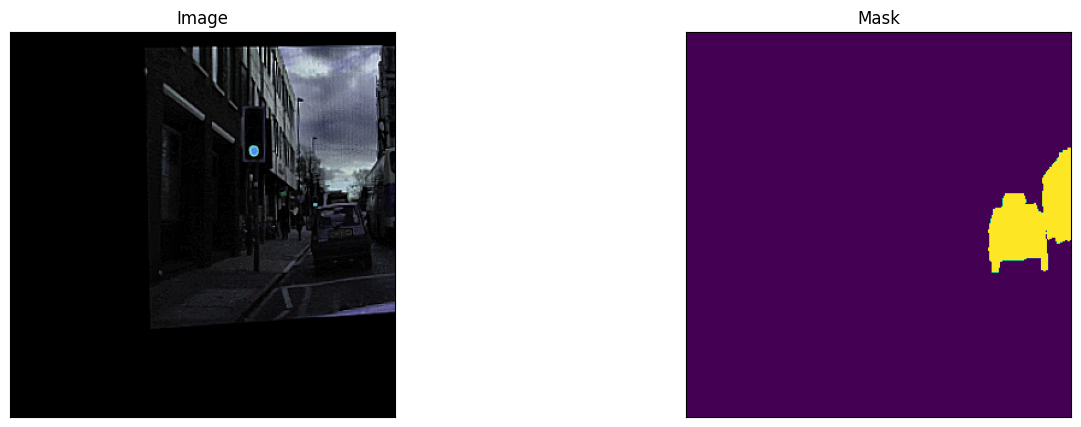

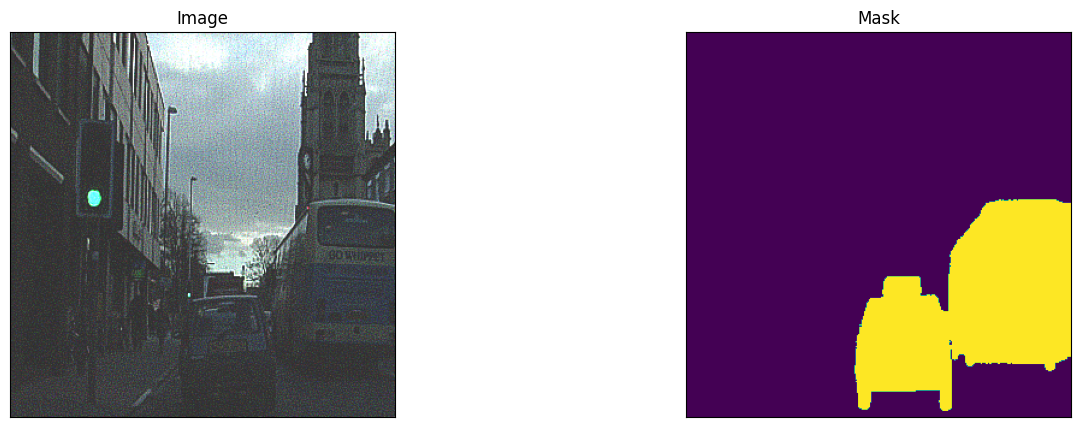

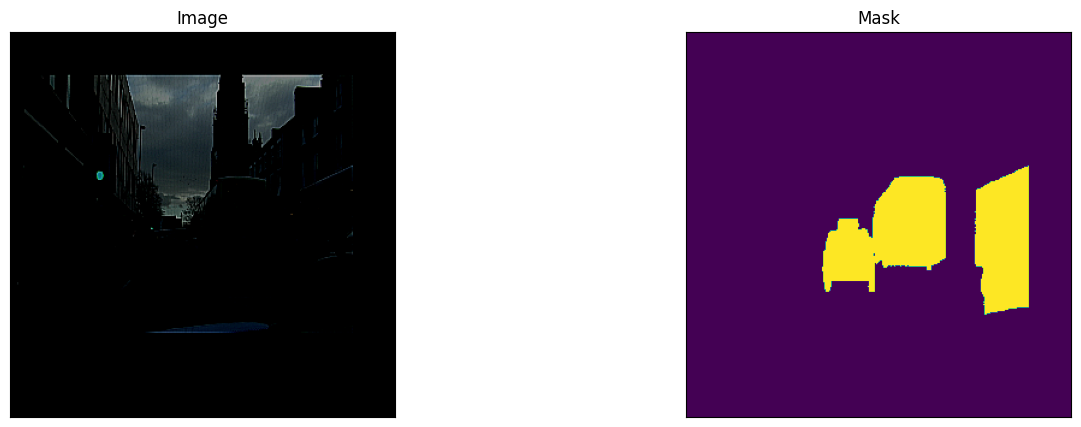

In [48]:
augmented_train_ds= MyDataSet(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_train_ds[1]
    visualize(image=image, mask=mask.squeeze(-1))

### **3. Train model**

In [53]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

print(f'Model: {model}')
print(f'Pretrained weights: {preprocessing_fn}')

Model: FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [68]:
train_dataset = MyDataSet(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = MyDataSet(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [69]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [70]:
train_epoch = ut.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ut.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [71]:
max_score = 0

for epoch in range(0, 40):
    
    print(f'\nEpoch: {epoch+1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '../models/resnet50_imagenet_40.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 101/101 [00:07<00:00, 13.87it/s, dice_loss - 0.4171, iou_score - 0.4773]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:05<00:00, 19.59it/s, dice_loss - 0.3665, iou_score - 0.5436]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:04<00:00, 25.22it/s, dice_loss - 0.2903, iou_score - 0.6187]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:03<00:00, 25.37it/s, dice_loss - 0.261, iou_score - 0.646] 
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:03<00:00, 25.33it/s, dice_loss - 0.2608, iou_score - 0.65]  
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [00:04<00:00, 25.11it/s, dice_loss - 0.284, iou_score - 0.6225]

Epoch: 7
valid: 100%|██████████| 101/101 [00:04<00:00, 24.87it/s, dice_loss - 0.2781, iou_score - 0.6309]

Epoch: 8
valid: 100%|██████████| 101/101 [00:04<00:00, 24.06it/s, dice_loss - 0.2441, iou_score - 0.666] 
Model saved!

Epoch: 9
valid: 100%|██████████| 101/101 [00:04<00:00, 24.95it/s, d

In [72]:
best_model = torch.load('../models/resnet50_imagenet_40.pth')

In [73]:
# create test dataset
test_dataset = MyDataSet(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [74]:
# evaluate model on test set
test_epoch = ut.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:13<00:00, 17.32it/s, dice_loss - 0.1989, iou_score - 0.7408]


In [75]:
test_dataset_vis = MyDataSet(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

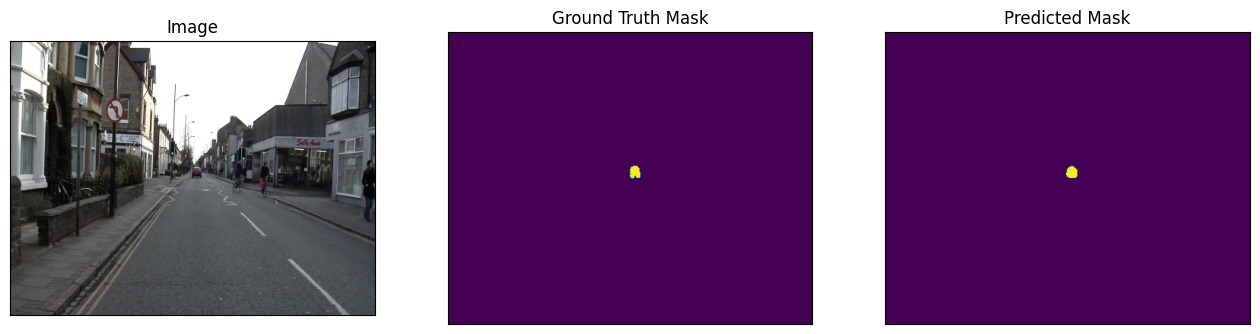

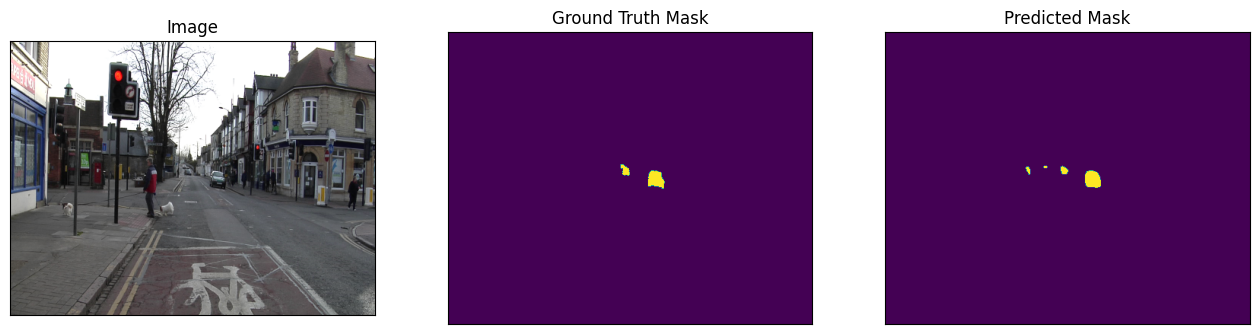

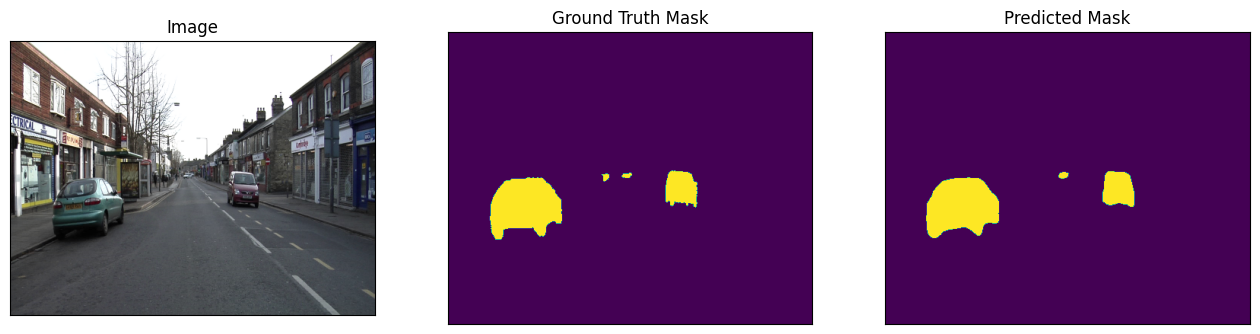

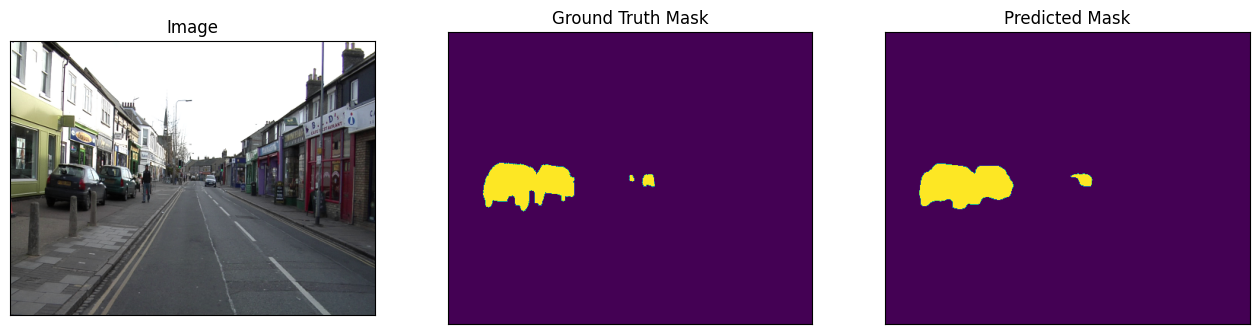

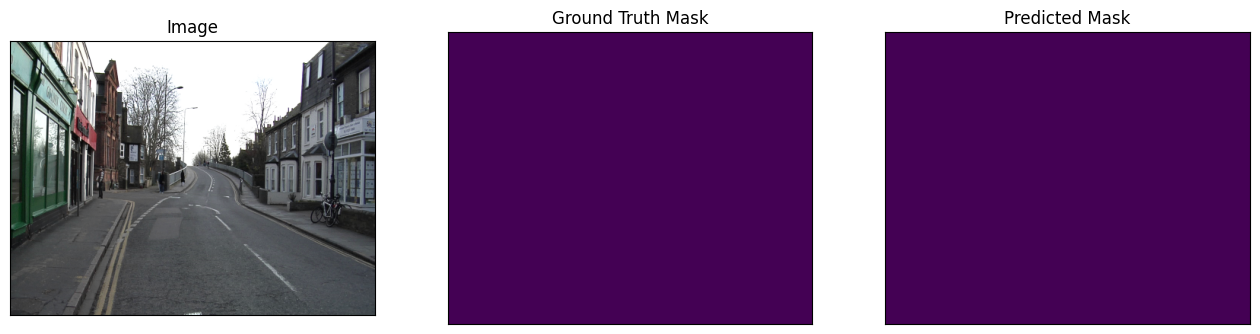

In [76]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )